# Tarea 9: Algoritmos de Monte-Carlo

Esta tarea consiste de sólo 4 problemas que son una modificación no tan grande de lo que se vio en los videos. Son todos relativamente fáciles, pero requieren un tiempo no tan pequeño para hacerlos puesto que correr los programas ya no es cuestión de segundos, sino de minitos y cada prueba que se hace lleva entonces minutos, lo que típicamente implica horas de espera entre todas las pruebas. 

1. Haz una función que calcule el área de una hiper-esfera de dimensión $N$ y radio $r$ usando integrales de Monte-Carlo. Para hacer esto usa ambos métodos: 
    (i) El método de los disparos.
    (ii) Usando la integral de la distribución de probabilidad de una variable aleatoria. 
    (iii) Finalmente compara tu resultado con el área que debería tener como función del número de puntos de Monte-Carlo.

In [1]:
using LinearAlgebra,Random,Distributions

In [2]:
##### Método del disparo
function S(n,N,r;δ=0.001)
    Δ=δ*r
    v2 = 0
    v1 = 0
    for i in 1:N
        X = []
        for k in 1:n
            push!(X,rand(Uniform(-r,r)))
        end
        if norm(X)<r-Δ
            v1+=1
        end
        if norm(X)<r+Δ
            v2+=1
        end
    end
    VT = (2*r)^n
    V2 = VT*v2/N
    V1 = VT*v1/N
    A = (V2-V1)/(2*Δ)
    return(A)
end

S (generic function with 1 method)

In [3]:
### Área de la 1-esfera, inmersa en R^2, de radio 1
S(2,100000,1)

5.819999999999936

In [4]:
### Valor "exacto"
2*pi

6.283185307179586

In [5]:
### Área de la 2-esfera, inmersa en R^3, de radio 2
S(3,1000000,2)

49.23199999999994

In [6]:
### Valor "exacto"
16*pi

50.26548245743669

### Método de Integral de función de densidad.
$$
A\left(S_{n-1}\right) = r^{n-1}\int_0^{2\pi}\int_0^{\pi}\cdots\int_0^{\pi}\sin^{n-2}\phi_1\sin^{n-3}\phi_2\cdots\sin\phi_{n-2}d\phi_1 d\phi_2 \cdots d\phi_{n-1}
$$
$$
A\left(S_{n-1}\right) = 2\pi r^{n-1} \Pi_{i=1}^{n-2}\int_0^\pi \sin^{n-i-1}\phi_i d\phi_i
$$

In [7]:
#### Integral usando la distribución uniforme y el promedio de la función
function ∫dU(f,a,b,N)
    S = 0
    for i in 1:N
        x = rand(Uniform(a,b))
        S += f(x)
    end
    return (b-a)*S/N
end
f(x)=sin(x)

f (generic function with 1 method)

In [9]:
∫dU(f,0,pi,10000)

2.012082953574097

In [10]:
function AS(n,r;N=1000000)
    I = 2*pi*r^(n-1)
    for i in 1:n-2
        f(x) = (sin(x))^(n-i-1)
        I = I*∫dU(f,0,pi,N)
    end
    return I
end

AS (generic function with 1 method)

In [11]:
AS(3,2)

50.32015348143406

In [12]:
16*pi

50.26548245743669

In [13]:
using Plots

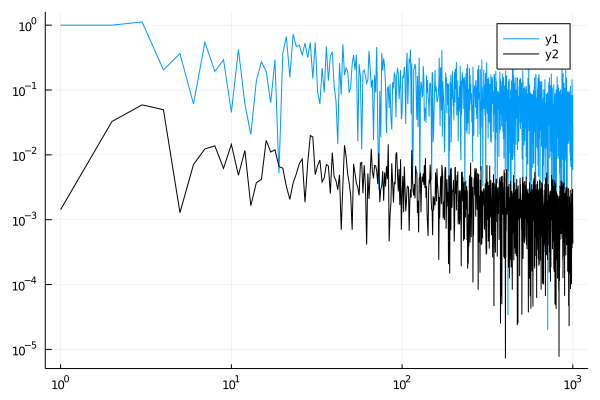

In [14]:
#### Comparación
num = 1e+3
r=2
n=3
AM=[]
AU=[]
Nn=1:1:num
I = 16*pi
for i in 1:num
    push!(AM,abs(S(n,i*100,r)-I)/I)
    push!(AU,abs(AS(n,r,N=i*100)-I)/I)
end
plot(AM,xaxis=:log,yaxis=:log)
plot!(AU,xaxis=:log,yaxis=:log,color=:black)

2. Da una interpreatación de caminantes aleatorios a la siguiente ecuación diferencial parcial y resuelvela (para alguna condición a la frontera que dibujes y una función $f(x,y)$ que tú decidas) usando caminantes aleatorios: 

$$\nabla u = c$$ con $c$ una constante y $\nabla$ el laplaciano. 

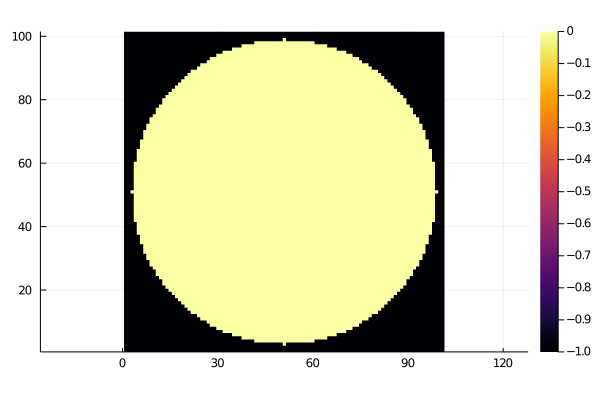

In [4]:
using Plots
n=101
m=101
h=51
k=51
r=48
retícula = zeros((n,m));
for i in 1:n
    for j in 1:m
        if ((i-h)^2 +(j-k)^2)>r^2 
            retícula[i,j]=-1
        end
    end
end
heatmap(retícula,aspect_ratio = :equal)

In [5]:
function posicion_permitida(i,j, retícula)
    if retícula[i,j] == -1 
        return false
    else
        return true
    end
end
function evoluciona_caminante(i,j, retícula)
    n = rand([1,2,3,4])
    if n == 1 
        return i + 1, j
    elseif n == 2
        return i - 1, j
    elseif n == 3
        return i, j + 1
    elseif n == 4
        return i, j - 1
    end
end 

function trayectoria_hasta_salir!(i,j, retícula)
    test = true
    I = [i]
    J = [j]
    while test
        i,j = evoluciona_caminante(i,j, retícula)
        push!(I, i)
        push!(J, j)
        test = posicion_permitida(i,j, retícula)
    end
    return I, J
end 
function minimum_positivo(matriz)
    n,m = size(matriz)
    x = Inf
    for i in 1:n, j in 1:m
        if matriz[i,j]<x && matriz[i,j] >= 0
            x = matriz[i,j]
        end
    end
    if x ≠ Inf
        return x
    else
        return 0
    end 
end
function mezcla_solucion_n(s, nc)  # Esta función simplemente sirve para hacer los promedios de la solución correctamente. 
    n,m = size(s)
    [nc[i,j] > 0 ? s[i,j]/nc[i,j] : NaN for i in 1:n, j in 1:m]
end

mezcla_solucion_n (generic function with 1 method)

In [9]:
function resuelve_Laplace(retícula, f, n;Print=false)    
    contador = 0
    n1, n2 = size(retícula)
    solución = zeros(n1,n2)
    numero_de_caminantes = [retícula[i,j]<0 ? -1 : 0 for i in 1:n1, j in 1:n2]
    while minimum_positivo(numero_de_caminantes)<n
        for i in 1:n1, j in 1:n2
            contador += 1
            if Print==true
                if mod(contador, 15000) == 0
                    println("revisando vertice ($i ,$j)")
                    println("numero maximo de caminantes = $(maximum(numero_de_caminantes))")
                    println("numero mínimo de caminantes = $(minimum_positivo(numero_de_caminantes))")
                    println(" ")
                end
            end
            test = posicion_permitida(i,j, retícula)
            if test
                x,y = trayectoria_hasta_salir!(i,j,retícula)
                s = f(x[end], y[end])
                for k in 1:length(x)-1
                    solución[x[k],y[k]] += s
                    numero_de_caminantes[x[k],y[k]] += 1
                end
            end
        end
    end
    return solución, numero_de_caminantes
end

resuelve_Laplace (generic function with 1 method)

In [19]:
using Random, Distributions
function resuelve_Laplace_p(retícula, n, c;Δ=1,Print=false)
    C = c*Δ^2/4
    contador = 0
    n1, n2 = size(retícula)
    solución = zeros(n1,n2)
    numero_de_caminantes = [retícula[i,j]<0 ? -1 : 0 for i in 1:n1, j in 1:n2]
    while minimum_positivo(numero_de_caminantes)<n
        for i in 1:n1, j in 1:n2
            contador += 1
            if Print==true
                if mod(contador, 15000) == 0
                    println("revisando vertice ($i ,$j)")
                    println("numero maximo de caminantes = $(maximum(numero_de_caminantes))")
                    println("numero mínimo de caminantes = $(minimum_positivo(numero_de_caminantes))")
                    println(" ")
                end
            end
            test = posicion_permitida(i,j, retícula)
            if test
                x,y = trayectoria_hasta_salir!(i,j,retícula)
                for k in 1:length(x)-1
                    distancia_borde = (sqrt((x[end]-x[k])^2 +(y[end]-y[k])^2 ))*C*Δ
                    solución[x[k],y[k]] += rand(Normal(distancia_borde,1)) 
                    numero_de_caminantes[x[k],y[k]] += 1
                end
            end
        end
    end
    return solución, numero_de_caminantes
end

resuelve_Laplace_p (generic function with 1 method)

In [ ]:
f(y,x) = 1/(y+1)
#Laplace_No_Homogénea(retícula,f,5,1;completo=true)
solución_H, numero_de_caminantes_H = resuelve_Laplace(retícula, f, 5)
ss_H = mezcla_solucion_n(solución_H, numero_de_caminantes_H);
#heatH = heatmap(ss_H, aspect_ratio = :equal)
#plot(heatH)
solución_p, numero_de_caminantes_p = resuelve_Laplace_p(retícula, 5,.01)
ss_p = mezcla_solucion_n(solución_p, numero_de_caminantes_p);
#heatp = heatmap(ss_p, aspect_ratio = :equal)
#plot(heatp)
SS = ss_H + ss_p
heatSS = heatmap(SS, aspect_ratio = :equal)
plot(heatSS)

3. Simula un sistema de 50 discos suaves en una caja (de lado $1$). Para esto considera un potencial de interacción $U(r_{i,j})$ que depende de $r_{i,j}$, la distancia entre el disco $i$ y el disco $j$ ($i \ne j$) igual al potencial de Lennard Jones  ($U(r_{i,j}) = \left(\frac{\sigma}{r_{i,j}}\right)^{12} - \left(\frac{\sigma}{r_{i,j}}\right)^6$, donde $\sigma$ es el diametro de los discos) si $r_{i,j} \le \sigma$ y $U(r_{i,j}) = 0$ cuando $r_{i,j} > \sigma$.

Tu simulación hazla similar a lo que se hizo en los videos. Comienza con discos de radio $0$ y crece el tamaño de esos discos hasta que se llegue a una fracción de empaquetamiento alta. Nota que esta vez la simulación sí depende de la temperatura (prueba con unas 3 o 4 temperaturas diferentes). 

Nota: La fracción de empaquetamiento es la suma del área de todos los discos dividido entre el área de la caja. 

4. Simula el modelo de Ising para una red hexagonal, es decir, cada vértice tiene 3 vecinos (y si dibujas la red, verás hexágonos). Para esto necesitas hacer 2 cambios importantes a lo visto en los videos: 
    
    (i) Modificar la función que produce los vecinos. 
    (ii) Modificar la función que grafica para que cada nodo lo ponga como un hexágono de un color si el espín apunta hacia arriba y de otro si apunta hacia abajo. 
    
    Revisa en particular los caso $J = -1/2$ y $J = 1/2$ y de este último obtén (haciendo un promedio de 5 casos nada más) la magnetización como función de la temperatura. 